## Second set of test runs - basic simulations, sparse fields where there is a mismeasurement of the PSFs (in terms of FWHM/shape/sigma).

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 16
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

2


(0.040776220254577049, 17.126097761280946, -74.0, 1713.7774843356319)
(0.15886556420021791, 17.203687502780589, -82.0, 1131.5017745269811)
(300.04077622025449, 17.126097761280946, 226.0, 2013.7774843356319)
(300.15886556420025, 17.203687502780589, 218.0, 1431.5017745269811)


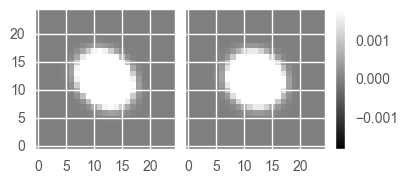

In [12]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

# Tweak the saved PSFs so the science PSF sigma is slightly wrong ("mis-measured"):
P_n = testObj.im2.psf
testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.9,2.1], theta=-35.)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

dit.plotImageGrid((P_n, testObj.im2.psf))

In [13]:
src = testObj.runTest(returnSources=True)

In [14]:
changedCentroid = np.array(testObj.centroids[testObj.changedCentroidInd, :])
print changedCentroid

#print src['AL'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']:
    print key
    if key is not 'SZOGY':
        fsKey = 'base_PsfFlux_fluxSigma'
    else: # For SZOGY, the correct flux measurement is PeakLikelihoodFlux
        fsKey = 'base_PeakLikelihoodFlux_fluxSigma'
    print src[key][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', fsKey, 'base_PsfFlux_flag']]

[[  242.21750369   271.65070471     0.          1500.        ]
 [  278.50448812   278.77794277     0.          1500.        ]
 [  256.96791745   291.09644383     0.          1500.        ]]
ALstack
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0            240.888933            271.229996              169.808188             False
1            278.162664            278.045964              171.114879             False
2            256.175003            291.135194              172.596413             False
ZOGY
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0             81.232161            245.153437              199.915518             False
1            275.190760            297.580564              203.551507             False
2            381.310957            229.235181              240.447873             False
3            241.895956            270.248932              165.973664             False
4    

In [15]:
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varFlux2=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)
testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.9,2.1], theta=-35.)

det = testObj.runTest()
print det

{'ZOGY': {'FP': 4, 'FN': 0, 'TP': 8}, 'ALstack': {'FP': 0, 'FN': 0, 'TP': 8}, 'SZOGY': {'FP': 1, 'FN': 0, 'TP': 8}, 'ALstack_noDecorr': {'FP': 0, 'FN': 0, 'TP': 8}}


Try some real tests!

In [22]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=50, n_varSources=1):
    #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             varFlux2=np.repeat(flux, n_varSources),
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=seed, psfSize=13)
    testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.9,2.1], theta=-35.)
    det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
    det['flux'] = flux
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

## Look at detection rates for 5.0-sigma sources.

In [ ]:
inputs = [(f, seed) for f in [1500] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10) \
                                                     for i in inputs)

100


FN: 
ALstack             1.68
ALstack_noDecorr    1.57
SZOGY               1.28
ZOGY                1.68
dtype: float64
FP: 
ALstack               0.27
ALstack_noDecorr      0.20
SZOGY                 0.30
ZOGY                115.84
dtype: float64
TP: 
ALstack             8.30
ALstack_noDecorr    8.41
SZOGY               8.69
ZOGY                8.30
dtype: float64


(-1, 4)

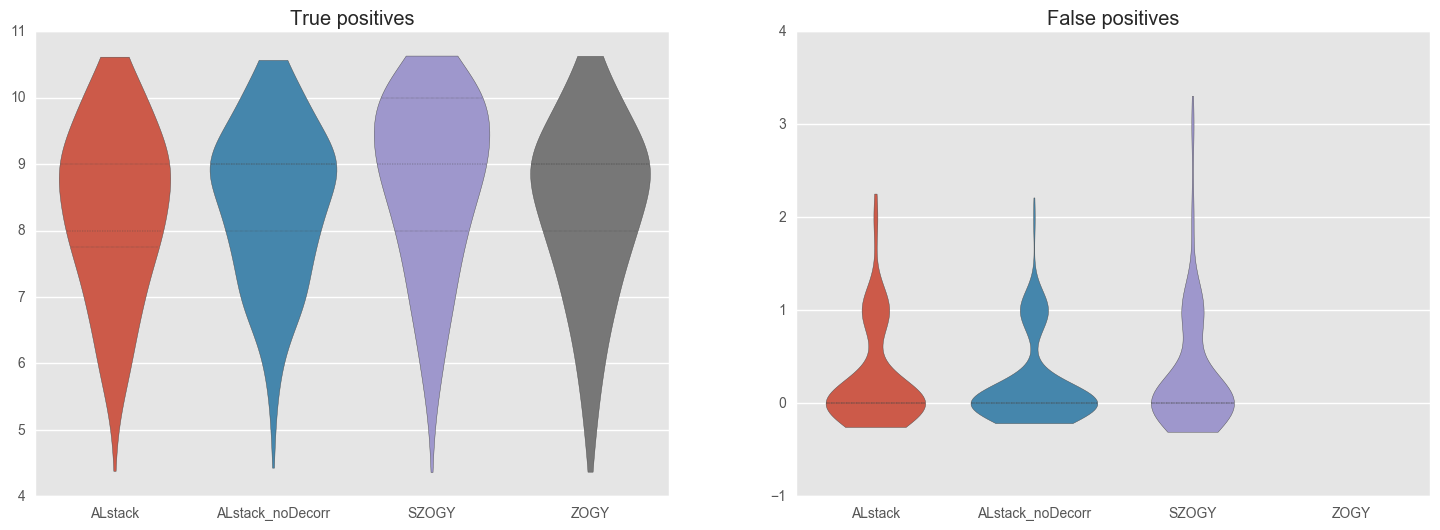

In [18]:
tr = testResults1
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
print 'FN:', '\n', FN.mean()
print 'FP:', '\n', FP.mean()
print 'TP:', '\n', TP.mean()

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
axes[0].set_ylim((4, 11))
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')
axes[1].set_ylim((-1, 4))

## Look at detection rates for 3.33-sigma sources.

In [12]:
inputs = [(f, seed) for f in [1000] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10) \
                                                     for i in inputs)

100


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 11.2min finished


In [19]:
tr = testResults2
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
print 'FN:', '\n', FN.mean()
print 'FP:', '\n', FP.mean()
print 'TP:', '\n', TP.mean()

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
axes[0].set_ylim((4, 11))
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')
axes[1].set_ylim((-1, 4))

NameError: name 'testResults2' is not defined

## For fun, try some 10-sigma sources.

In [ ]:
inputs = [(f, seed) for f in [3000] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10) \
                                                     for i in inputs)

100


In [20]:
tr = testResults3
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
print 'FN:', '\n', FN.mean()
print 'FP:', '\n', FP.mean()
print 'TP:', '\n', TP.mean()

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
axes[0].set_ylim((4, 11))
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')
axes[1].set_ylim((-1, 4))

NameError: name 'testResults3' is not defined